# Training a variational quantum circuit with Pennylane

In this notebook, we will learn how to build and train a variational quantum circuit (VQA) to generate a predefined 4 qubit target state from a 4 qubit random state of our choice.  

In [1]:
import matplotlib.pyplot as plt
import numpy

from pennylane import numpy as np
import pennylane as qml
import torch
from torch.autograd import Variable

## Introduction

Given the following predefined 4 qubit states: $\lvert 0011 \rangle$, $\lvert 0101 \rangle$, $\lvert 1010 \rangle$, $\lvert 1100 \rangle$. Our goal is to create a quantum circuit that can do the following mapping:

- Initial random state 1, returns $\lvert 0011 \rangle$.
- Initial random state 2, returns $\lvert 0101 \rangle$.
- Initial random state 3, returns $\lvert 1010 \rangle$.
- Initial random state 4, returns $\lvert 1100 \rangle$.

However, for the sake of simplicity in the first section, I am going to also predefine the initial random state. In the second section, we will see how the code in the first section can be extended to solve the initial statement.

$$\lvert 0001 \rangle \rightarrow  \lvert 0011 \rangle $$
$$\lvert 0010 \rangle \rightarrow  \lvert 0101 \rangle $$
$$\lvert 0100 \rangle \rightarrow  \lvert 1010 \rangle $$
$$\lvert 1000 \rangle \rightarrow  \lvert 1100 \rangle $$


In [2]:
initial_states = [
    np.array([0, 0, 0, 1]),
    np.array([0, 0, 1, 0]),
    np.array([0, 1, 0, 0]),
    np.array([1, 0, 0, 0])
]


target_states = [
    np.array([0, 0, 1, 1]),
    np.array([0, 1, 0, 1]),
    np.array([1, 0, 1, 0]),
    np.array([1, 1, 0, 0])
]

## Defining a circuit

The most difficult part of defining a circuit is to choose a good ansatz. Since I don't have a clue of what will work best I will implement a general circuit parametrized. Using 2 rotational qubit gates (Rx and Ry) I can generate all possible states in the Bloch Sphere. Then, I will implement several CNOT gates to entangle all the qubits. 

I will repeat this layer (rotation gates + CNOT gates) 2 times. The number of layers is a hyperparameter that we may need to tune later.

**Important:**  We need to set the parameters for the rotational gates, since I want to generate all possible angles, I will generate random numbers from $0$ to $\pi$.

<font color=red>'NOT COMPLETLY SURE'</font>  
In the [tutorial](https://pennylane.ai/qml/demos/tutorial_state_preparation.html) generates random numbers from 0 to pi. This is enough to generat all possible states in the bloch sphere.

In [3]:
n_qubits = 4
n_layers = 2
n_rotations = 2

# randomly initialize parameters from a normal distribution
params = np.random.normal(0, np.pi, (n_qubits, n_layers, n_rotations))
params = Variable(torch.tensor(params), requires_grad=True)

def circuit_layer(n_qubits: int , params: np.array, layer_lvl: int):
    for i in range(n_qubits):
        qml.RX(params[i, layer_lvl, 0], wires=i)
        qml.RY(params[i, layer_lvl, 1], wires=i)

    # Entangling all qubits
    qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="all_to_all")

Now, we will define our circuit in 3 steps: 


**1. Initialize in the right state.**  
All circuits start with all qubits in the zero state, $\lvert 0\rangle$. Using ```qml.BasisState``` our circuit will start with the state of our choice: $\lvert 0001 \rangle$ or $\lvert 0010 \rangle$, etc.

**2. Implement the layer.**  
Using a simple for loop we can add as many layers as we want.

**3. Measurement.**    
In this last step, we will measure the **fidelity** between the **output state** and **target state**. The fidelity is a value between 0 (orthogonal) or 1 (equal) that measure the closeness between two states, in other words, it measures if both states are similar or not. 

In [4]:
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def circuit(params, initial_state, fidelity_op, n_layers):
    n_qubits = len(initial_state)

    qml.BasisState(initial_state, wires=range(n_qubits))
    
    for layer_lvl in range(n_layers):
        circuit_layer(n_qubits, params, layer_lvl)

    return qml.expval(qml.Hermitian(fidelity_op, wires=range(n_qubits)))

## Define a cost function

The cost function helps the circuit to find the target state. In this case, our cost function will be the fidelity, so we can simply define our cost function as:

$$ C(\theta) = \sum \big( 1-\langle \psi_o(\theta) \lvert \psi_t \rangle \big) ^2 $$

where $\theta$ are the variational parameters that the circuit needs to tune, $\psi_o$ is the output state, $\psi_t$ is one of the target states that we have define in the begining and $\langle \psi_o(\theta) \lvert \psi_t \rangle$ is how the fidelity is computed.


### Explaining fidelity_op (Extra)

_I have written this subsection in case someone needs to understand how to implement the fidelity operator._

Suppose I have the inital state $\lvert 00 \rangle$ and our target is $\lvert 01 \rangle$. If our quantum circuit doesn't works properly it can outputs states like:
- $\lvert 10 \rangle$
- $\lvert 11 \rangle$.  

But which state is closer to the target? In order to answer this question we can compute the fidelity operator of our target state ($\lvert 01 \rangle \langle 01 \rvert$).
$$ \lvert 01 \rangle \langle 01 \rvert = \begin{pmatrix}
0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
\end{pmatrix}$$

And measure how close each state is:  
**State  $\lvert 10 \rangle$**:

$$ \begin{pmatrix}
0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
\end{pmatrix}
\begin{pmatrix}
0  \\
0  \\
1  \\
0  \\
\end{pmatrix}
= 0$$ 

**State  $\lvert 11 \rangle$**:

$$ \begin{pmatrix}
0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
\end{pmatrix}
\begin{pmatrix}
0  \\
0  \\
0  \\
1  \\
\end{pmatrix}
= 0$$ 

**IMPORTANT**

Even though state $\lvert 11 \rangle$ is closer to $\lvert 01 \rangle$ (there is only 1 qubit wrong), the fidelity interprets that both $\lvert 11 \rangle$ and $\lvert 10 \rangle$ are far away from $\lvert 01 \rangle$.

<font color=red>'ASK'</font>  
_Perhaps the fidelity is not a good cost function for this case. <font color=red>Future myself answer this question</font>_

In [5]:
def tensor_product(matrices: list):
    if len(matrices)==2:
        return np.kron(matrices[0], matrices[1], requires_grad=False)
    return np.kron(matrices[0], tensor_product(matrices[1:]), requires_grad=False)


def density_matrix(state: np.array):
    # Define |0> and |1>
    zero_state = np.array([1, 0], requires_grad=False)
    one_state = np.array([0, 1], requires_grad=False)

    # Computes density matrix
    matrices = [zero_state if qubit_state == 0 else one_state for qubit_state in state]
    vector = tensor_product(matrices)
    return np.outer(vector, np.conj(vector), requires_grad=False)


def cost(params, initial_states, target_states, n_layers):
    loss = 0
    fidelity_operators = [density_matrix(i) for i in target_states]
    for i in range(len(target_states)):
        fidelity = circuit(params, initial_states[i], fidelity_operators[i], n_layers)
        loss += (1 - fidelity) ** 2

    return loss / len(target_states)

To find the best parameters I use the code that you can find in this [tutorial](https://pennylane.ai/qml/demos/tutorial_state_preparation.html). Using a classical optimizer we can find the best parameters that minimize the previous cost function.

In [6]:
# set up the optimizer
opt = torch.optim.Adam([params], lr=0.1)

# number of steps in the optimization routine
steps = 200

# the final stage of optimization isn't always the best, so we keep track of
# the best parameters along the way
best_cost = cost(params, initial_states, target_states, n_layers)
best_params = np.zeros((n_qubits, n_layers, n_rotations))

print("Cost after 0 steps is {:.4f}".format(best_cost))

# optimization begins
for n in range(steps):
    opt.zero_grad()
    loss = cost(params, initial_states, target_states, n_layers)
    loss.backward()
    opt.step()

    # keeps track of best parameters
    if loss < best_cost:
        best_cost = loss
        best_params = params

    # Keep track of progress every 10 steps
    if n % 10 == 9 or n == steps - 1:
        print("Cost after {} steps is {:.4f}".format(n + 1, loss))

Cost after 0 steps is 0.8170


/media/gllodra12/extended_linux/Projectes/Quantum_projects/qosf/qosf_2021_09/venv/lib/python3.8/site-packages/torch/autograd/__init__.py:147: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:240.)
  Variable._execution_engine.run_backward(


Cost after 10 steps is 0.6030
Cost after 20 steps is 0.3905
Cost after 30 steps is 0.3942
Cost after 40 steps is 0.3764
Cost after 50 steps is 0.3772
Cost after 60 steps is 0.3754
Cost after 70 steps is 0.3752
Cost after 80 steps is 0.3751
Cost after 90 steps is 0.3750
Cost after 100 steps is 0.3750
Cost after 110 steps is 0.3750
Cost after 120 steps is 0.3750
Cost after 130 steps is 0.3750
Cost after 140 steps is 0.3750
Cost after 150 steps is 0.3750
Cost after 160 steps is 0.3750
Cost after 170 steps is 0.3750
Cost after 180 steps is 0.3750
Cost after 190 steps is 0.3750
Cost after 200 steps is 0.3750


This results don't look really promising, perhaps we will need to increase the number of layers.  

In [7]:
def check_results(best_params, initial_states, target_states, n_layers):
    fidelity_operators = [density_matrix(i) for i in target_states]
    
    for initial_state, fidelity_op in zip(initial_states, fidelity_operators):
        fidelity = circuit(best_params, initial_state, fidelity_op, n_layers)
        print("From the initial state {} we get an output with fidelity {:.4f}".format(initial_state, fidelity))

check_results(best_params, initial_states, target_states, n_layers=2)

From the initial state [0 0 0 1] we get an output with fidelity 0.0000
From the initial state [0 0 1 0] we get an output with fidelity 0.5000
From the initial state [0 1 0 0] we get an output with fidelity 0.5000
From the initial state [1 0 0 0] we get an output with fidelity 0.9993


## Conclusion 1st circuit

Our circuit is not able to generate the target states. We only get a good result with the input $\lvert 1000 \rangle$ because its fidelity is close to 1, which means that the output state is really close to the target state, $\lvert 1100 \rangle$.

Let's see if increasing the number of layers our results will improve.

In [8]:
def train(initial_states, target_states, n_layers, verbose=True):
    n_qubits = initial_states[0].size

    # Total of rotations gates (Rx and Ry)
    n_rotations = 2
    
    # Setting intial parameters
    params = np.random.normal(0, np.pi, (n_qubits, n_layers, n_rotations))
    params = Variable(torch.tensor(params), requires_grad=True)
    
    # Computing the best parameters
    opt = torch.optim.Adam([params], lr=0.1)

    # number of steps in the optimization routine
    steps = 200

    # the final stage of optimization isn't always the best, so we keep track of the best parameters along the way
    best_cost = cost(params, initial_states, target_states, n_layers)
    best_params = np.zeros((n_qubits, n_layers, n_rotations))

    if verbose:
        print("Cost after 0 steps is {:.4f}".format(best_cost))

    # optimization begins
    for n in range(steps):
        opt.zero_grad()
        loss = cost(params, initial_states, target_states, n_layers)
        loss.backward()
        opt.step()

        # keeps track of best parameters
        if loss < best_cost:
            best_cost = loss
            best_params = params

        # Keep track of progress every 10 steps
        if n % 10 == 9 or n == steps - 1:
            if verbose:
                print("Cost after {} steps is {:.4f}".format(n + 1, loss))
    
    return best_params, loss

In [9]:
best_params_10, _ = train(initial_states, target_states, 10)

Cost after 0 steps is 0.7972
Cost after 10 steps is 0.1736
Cost after 20 steps is 0.1116
Cost after 30 steps is 0.0494
Cost after 40 steps is 0.0249
Cost after 50 steps is 0.0213
Cost after 60 steps is 0.0176
Cost after 70 steps is 0.0148
Cost after 80 steps is 0.0130
Cost after 90 steps is 0.0109
Cost after 100 steps is 0.0086
Cost after 110 steps is 0.0069
Cost after 120 steps is 0.0060
Cost after 130 steps is 0.0055
Cost after 140 steps is 0.0052
Cost after 150 steps is 0.0049
Cost after 160 steps is 0.0047
Cost after 170 steps is 0.0045
Cost after 180 steps is 0.0042
Cost after 190 steps is 0.0040
Cost after 200 steps is 0.0038


In [10]:
check_results(best_params_10, initial_states, target_states, n_layers=10)

From the initial state [0 0 0 1] we get an output with fidelity 0.9375
From the initial state [0 0 1 0] we get an output with fidelity 0.9435
From the initial state [0 1 0 0] we get an output with fidelity 0.9361
From the initial state [1 0 0 0] we get an output with fidelity 0.9362


## Conclusion 2nd circuit

Much better!

Using 10 layers our circuit is able to generate output states that are REALLY close to the target states. We could increase the number of layers on our system but the results wouldn't improve drastically.

<font color=red>'ASK'</font>  
Why I need to use CNOT gates if neither the initial state nor the output state has entanglement???

In [11]:
layers = range(2, 14)
loss_list = list()

for n_layers in layers:
    print("Computing layer=", n_layers)
    _, loss = train(initial_states, target_states, n_layers, verbose=False)
    loss_list.append(loss.data)

Computing layer= 2
Computing layer= 3
Computing layer= 4
Computing layer= 5
Computing layer= 6
Computing layer= 7
Computing layer= 8
Computing layer= 9
Computing layer= 10
Computing layer= 11
Computing layer= 12
Computing layer= 13


Text(0, 0.5, 'loss')

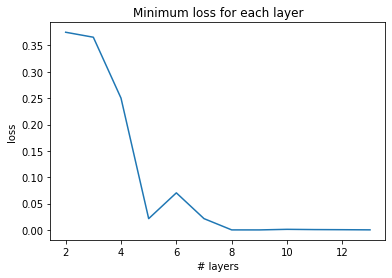

In [14]:
plt.plot(layers, loss_list)
plt.title("Minimum loss for each layer")
plt.xlabel("# layers")
plt.ylabel("loss")

## What would happen if we provided a different input state? 

Our model is able to perform the initial task proposed in the introduction. But what will happen if we have a different input state.

- Will this input state become one of the target states?
- Will this input state become a totally different state?

In order to answer these questions, we will check if the fidelity is close to any of the target states?

In [15]:
initial_states = [
    np.array([0, 1, 1, 1]),
    np.array([0, 1, 1, 1]),
    np.array([0, 1, 1, 1]),
    np.array([0, 1, 1, 1])
]

check_results(best_params_10, initial_states, target_states, n_layers=10)

From the initial state [0 1 1 1] we get an output with fidelity 0.0015
From the initial state [0 1 1 1] we get an output with fidelity 0.0095
From the initial state [0 1 1 1] we get an output with fidelity 0.0064
From the initial state [0 1 1 1] we get an output with fidelity 0.0218


The state $\lvert 0111 \rangle $ is map to a completly new state that is not close to any of the target states. Hence, our model is not overfitted to the 4 predefined targets.

_For some readers this may come as no surprise since if we apply different inputs to the same transformations (Rx, Ry, CNOT) it will usually generate different outputs._

## References

1. Training a circuit with PyTorch: https://pennylane.ai/qml/demos/tutorial_state_preparation.html
2. Cost function: https://pennylane.ai/qml/demos/tutorial_data_reuploading_classifier.html


## Future steps

- Train the VQA using a totally random input state.
- Use a different cost function, try implemeting the cost function in this [tutorial](https://pennylane.ai/qml/demos/tutorial_state_preparation.html).
- Plot probabilities of measuring different states.  
_Although fidelity is clear to me, I think that the reader will have a better understanding of the output if I show a bar plot with probabilities_.

### Extra 1: Random input state

In this section I want to see if the circuit is powerful enough to get the predefined targets using any random input state.

To generate a random 4-qubit quantum state we will define a computational basis for 4-qubits and add random amplitudes ($c_0, c_1, c_2, c_3$).

$$ \psi = c_0\lvert 0 \rangle + c_1\lvert 1 \rangle + c_2\lvert 2 \rangle + c_3\lvert 3 \rangle $$

Recall that the quantum state must be normalized, so we need to impose the following constraint when we generate random values: 

$$|c_0|^2+|c_1|^2+|c_2|^2+|c_3|^2=1$$

In [108]:
dev2 = qml.device("default.qubit", wires=n_qubits)
def get_angles(n_qubits, n_rotations):
    return numpy.random.uniform(low=-np.pi, high=np.pi, size=(n_qubits, n_rotations))


@qml.qnode(dev2, interface="torch")
def circuit_random_input(params, random_angles, fidelity_op, n_layers):
    n_qubits = len(random_angles)

    # Initial state is random
    for i in range(n_qubits):
        qml.RX(random_angles[i, 0], wires=i)
        qml.RY(random_angles[i, 1], wires=i)
    
    for layer_lvl in range(n_layers):
        circuit_layer(n_qubits, params, layer_lvl)

    return qml.expval(qml.Hermitian(fidelity_op, wires=range(n_qubits)))

In [109]:
def cost_random_input(params, random_angles, target_states, n_layers):
    loss = 0
    fidelity_operators = [density_matrix(i) for i in target_states]
    for i in range(len(target_states)):
        
        fidelity = circuit_random_input(params, random_angles[i], fidelity_operators[i], n_layers)
        loss += (1 - fidelity) ** 2

    return loss / len(target_states)

In [110]:
def train(random_angles, target_states, n_layers, verbose=True):
    n_qubits = initial_states[0].size

    # Total of rotations gates (Rx and Ry)
    n_rotations = 2
    
    # Setting intial parameters
    params = np.random.normal(0, np.pi, (n_qubits, n_layers, n_rotations))
    params = Variable(torch.tensor(params), requires_grad=True)
    
    # Computing the best parameters
    opt = torch.optim.Adam([params], lr=0.1)

    # number of steps in the optimization routine
    steps = 200

    # the final stage of optimization isn't always the best, so we keep track of the best parameters along the way
    best_cost = cost_random_input(params, random_angles, target_states, n_layers)
    best_params = np.zeros((n_qubits, n_layers, n_rotations))

    if verbose:
        print("Cost after 0 steps is {:.4f}".format(best_cost))

    # optimization begins
    for n in range(steps):
        opt.zero_grad()
        loss = cost_random_input(params, random_angles, target_states, n_layers)
        loss.backward()
        opt.step()

        # keeps track of best parameters
        if loss < best_cost:
            best_cost = loss
            best_params = params

        # Keep track of progress every 10 steps
        if n % 10 == 9 or n == steps - 1:
            if verbose:
                print("Cost after {} steps is {:.4f}".format(n + 1, loss))
    
    return best_params, loss

In [111]:
n_qubits = 4
n_rotations = 2
random_angles = [
    get_angles(n_qubits, n_rotations),
    get_angles(n_qubits, n_rotations),
    get_angles(n_qubits, n_rotations),
    get_angles(n_qubits, n_rotations)
]

best_params_10_random, _ = train(random_angles, target_states, 10)

Cost after 0 steps is 0.8475
Cost after 10 steps is 0.2007
Cost after 20 steps is 0.0931
Cost after 30 steps is 0.0510
Cost after 40 steps is 0.0366
Cost after 50 steps is 0.0273
Cost after 60 steps is 0.0216
Cost after 70 steps is 0.0179
Cost after 80 steps is 0.0151
Cost after 90 steps is 0.0130
Cost after 100 steps is 0.0116
Cost after 110 steps is 0.0107
Cost after 120 steps is 0.0103
Cost after 130 steps is 0.0100
Cost after 140 steps is 0.0098
Cost after 150 steps is 0.0096
Cost after 160 steps is 0.0095
Cost after 170 steps is 0.0094
Cost after 180 steps is 0.0093
Cost after 190 steps is 0.0093
Cost after 200 steps is 0.0092


In [112]:
def check_results(best_params, initial_states, target_states, n_layers):
    fidelity_operators = [density_matrix(i) for i in target_states]
    
    for initial_state, fidelity_op in zip(initial_states, fidelity_operators):
        fidelity = circuit_random_input(best_params, initial_state, fidelity_op, n_layers)
        print("From the initial state {} we get an output with fidelity {:.4f}".format(initial_state, fidelity))


check_results(best_params_10_random, random_angles, target_states, n_layers=2)

From the initial state [[-0.08855378 -1.57165424]
 [ 2.65706645  1.377499  ]
 [-0.5878746   2.14034843]
 [ 0.34437392  2.23182031]] we get an output with fidelity 0.0434
From the initial state [[-1.2326853  -3.07984891]
 [ 0.69989569  0.94409433]
 [-1.91104108 -2.09554331]
 [ 2.66857245 -0.48458581]] we get an output with fidelity 0.0655
From the initial state [[-0.35346274  2.5456956 ]
 [ 2.16778511 -2.53245629]
 [-1.42096702  2.19848307]
 [ 2.98342779 -3.10523836]] we get an output with fidelity 0.1660
From the initial state [[-2.57758387 -1.37407536]
 [ 2.58046831 -1.2032229 ]
 [ 2.79449017  2.96541478]
 [-0.93978942 -0.66409163]] we get an output with fidelity 0.0590
